In [1]:
import sys, re
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import HTMLParser
from nltk import word_tokenize
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
final = False

lowercase = True
lemmatize = False
tokenize = False
split = True
n=3
splitratio = 0.8

stemmer = PorterStemmer()

In [3]:
def split_test_train_data(X,Y,splitratio):
    split = int(splitratio* X.shape[0])
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = Y[:split], Y[split:]
    return X_train, X_test, y_train, y_test

def cleanHtml(raw_html):
    cleantext = re.sub(r"(?:\@|https?\://)\S+", "", raw_html)
    return cleantext

def cleanSpeaker(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext

def removeNonAscii(text):
    return re.sub(r'[^\x00-\x7F]+',' ', text)

def remStopPuncEncodings(tokens):
    punctuation = list(string.punctuation)
    htmlEncodings = [ '&quot', '&amp', '&lt','&gt', 'com', 'org']
    stoplist = set(stopwords.words('english') +  punctuation + htmlEncodings )
    s = [w for w in tokens if not w in stoplist]
    return s

def stem_tokens(tokens, stemmer):
    stemmed =[]
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def removeAposFollowed(text):
    return re.sub(r"'.", "", text)

def stripSplitText(text):
    text = text.strip()
    return text.split()

def removeDigit(text):
    return filter(lambda c: not c.isdigit(), text)

def removeAtUser(text):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())

def processText(text):
    text = text.encode('ascii', 'ignore')
    text = removeAtUser(text)
    text = removeAposFollowed(text)
    text = removeDigit(text)
    text = cleanSpeaker(text)
    if tokenize:
        tokens = word_tokenize(text)
    elif split:
        tokens = stripSplitText(text)
    tokens = remStopPuncEncodings(tokens)
    string = (' ').join(tokens)
    return string

In [4]:
# evaluation code

from sklearn.metrics import confusion_matrix,classification_report


def accuracy(gold, predict):
    assert len(gold) == len(predict)
    corr = 0
    for i in xrange(len(gold)):
        if gold[i] == predict[i]:
            corr += 1
    acc = float(corr) / len(gold)
    print 'Accuracy %d / %d = %.4f' % (corr, len(gold), acc)
        
def con_class_matrix(gold,predict):
    cm = confusion_matrix(gold, predict)
    target_names =['nfl','movies','hockey','news','worldnews','politics','nba','soccer']
    print '\n Confusion Matrix:\n', cm
    print '\nClasification report:\n', classification_report(gold,predict,target_names=target_names)
    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [5]:
print "Reading files........................",
sys.stdout.flush()
train_inp = pd.read_csv('data/train_input.csv').values
test_inp = pd.read_csv('data/test_input.csv').values
train_label = pd.read_csv('data/train_output.csv').values

Reading files........................


In [6]:
print "Preprocessing Text..................."
size = train_inp.shape[0]
for i in range(size):
    train_inp[i][1] = processText(train_inp[i][1])

test_size = test_inp.shape[0]
for i in range(test_size):
    test_inp[i][1] = processText(test_inp[i][1])

print "Done."

Preprocessing Text...................
Done.


In [7]:
# Split into training and validation sets
v_split = int(0.9 * train_inp.shape[0])
ids_trn = train_inp[:v_split,0].astype(int)
ids_val = train_inp[v_split:,0].astype(int)
ids_all = train_inp[:,0].astype(int)
ids_tst = test_inp[:,0].astype(int)

trainX = train_inp[:v_split,1]
valX = train_inp[v_split:,1]
allX = train_inp[:,1]
testX = test_inp[:,1]

trainY = np.array(train_label[:v_split,1])[:,None]
valY =  np.array(train_label[v_split:,1])[:,None]
allY = np.array(train_label[:,1])[:,None]

combinedTrainTest = np.hstack((allX, testX))

In [24]:
print "Building vectorizer..................",
sys.stdout.flush()
vectorizer = CountVectorizer(stop_words='english',
                             lowercase=True,
                             max_features=8000,
                             min_df=1,max_df=0.9)
ng_vectorizer = CountVectorizer(ngram_range=(1,n),
                                stop_words='english',
                                lowercase=True,
                                max_features=8000,
                                min_df=1)
print "Done."

Building vectorizer.................. Done.


In [25]:
print "Building TF-IDF transformer..........",
sys.stdout.flush()
transformer = TfidfTransformer()
print "Done."

Building TF-IDF transformer.......... Done.


In [26]:
print "Extracting training features.........",
sys.stdout.flush()
trainXCounts = vectorizer.fit_transform(trainX)
trainXCounts = sparse.hstack((trainXCounts,
                              ng_vectorizer.fit_transform(trainX)))

valXCounts = vectorizer.transform(valX)
valXCounts = sparse.hstack((valXCounts,
                              ng_vectorizer.transform(valX)))

print "Done."

Extracting training features......... Done.


In [27]:
print "Extracting testing features..........",
sys.stdout.flush()
vectorizer.fit(combinedTrainTest)
ng_vectorizer.fit(combinedTrainTest)
allXCounts = vectorizer.transform(allX)
allXCounts = sparse.hstack((allXCounts,
                              ng_vectorizer.transform(allX)))
testXCounts = vectorizer.transform(testX)
testXCounts = sparse.hstack((testXCounts,
                              ng_vectorizer.transform(testX)))

print "Done."

Extracting testing features.......... Done.


In [28]:
print "Applying TF-IDF transform............",
sys.stdout.flush()
trainX_tfidf = transformer.fit_transform(trainXCounts)
valX_tfidf = transformer.transform(valXCounts)

allX_tfidf = transformer.fit_transform(allXCounts)
testX_tfidf = transformer.transform(testXCounts)
print "Done."

Applying TF-IDF transform............ Done.


In [29]:
X_trn = trainX_tfidf
X_val = valX_tfidf
X_all = allX_tfidf
X_tst = testX_tfidf

ids_trn, X_trn = X_trn[:,0].toarray().astype(int), X_trn[:,1:]
ids_val, X_val = X_val[:,0].toarray().astype(int), X_val[:,1:]
ids_all, X_all = X_all[:,0].toarray().astype(int), X_all[:,1:]
ids_tst, X_tst = X_tst[:,0].toarray().astype(int), X_tst[:,1:]

Y_trn = trainY.flatten()
Y_val = valY.flatten()
Y_all = allY.flatten()


In [31]:
from sklearn.neighbors import KNeighborsClassifier

print "Knn Classifier on Test Set"
model = KNeighborsClassifier()
model.fit(X_trn,Y_trn)
#makepredictions
expected = Y_val
predicted = model.predict(X_val)
print "   Validation set accuracy: "
accuracy(expected,predicted)
con_class_matrix(expected,predicted)

Logistic Regression Model on Test Set
   Validation set accuracy: 
Accuracy 15162 / 16500 = 0.9189

 Confusion Matrix:
[[1950   13   17   16   32    4   16    3]
 [   8 2226    5   20    2    4    4   12]
 [  25    9 1680    8   33    7    8    3]
 [   3   20    6 1677    6  204    4  156]
 [  32    7   31   15 1944    1   14    1]
 [   2    4    1  211    4 1643    2   40]
 [  30    5   12   10   11    1 2129   18]
 [   2   21    0  136    0   52   27 1913]]

Clasification report:
             precision    recall  f1-score   support

        nfl       0.95      0.95      0.95      2051
     movies       0.97      0.98      0.97      2281
     hockey       0.96      0.95      0.95      1773
       news       0.80      0.81      0.80      2076
  worldnews       0.96      0.95      0.95      2045
   politics       0.86      0.86      0.86      1907
        nba       0.97      0.96      0.96      2216
     soccer       0.89      0.89      0.89      2151

avg / total       0.92      0.92  

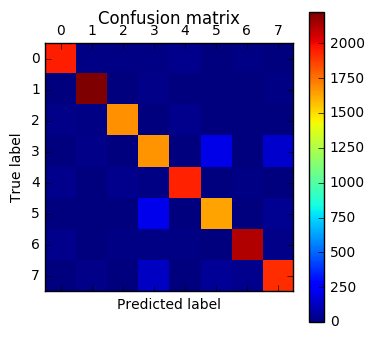

In [41]:
from sklearn.linear_model import LogisticRegression

print "Logistic Regression Model on Test Set"
model = LogisticRegression(solver='lbfgs', penalty='l2',C=10)
model.fit(X_trn,Y_trn)
#makepredictions
expected = Y_val
predicted = model.predict(X_val)
print "   Validation set accuracy: "
accuracy(expected,predicted)
con_class_matrix(expected,predicted)


In [28]:
print "   Training on all data.................",
sys.stdout.flush()
model.fit(X_all, Y_all)
print "Done."


print "Predictions on test file........................"
sys.stdout.flush()
predictTest = model.predict(X_tst)
predict_file = pd.DataFrame(columns=['id','category'])
predict_file.id= range(X_tst.shape[0])
predict_file.category = predictTest


predict_file.to_csv('predictions/Y_test_Logistic.csv',index=False)
print "Done."

   Training on all data................. Done.
Predictions on test file........................
Done.


In [128]:
print '0.90875 Accuracy on Kaggle DataSet'

0.90875 Accuracy on Kaggle DataSet


Multinomial Naive Bayes Classifier on Test Set
   Validation set accuracy: 
Accuracy 14854 / 16500 = 0.9002

 Confusion Matrix:
[[1949   19   15   13   29    3   17    6]
 [   6 2209    4   28    1    3    9   21]
 [  35    8 1671   12   31    2   10    4]
 [   6   43    4 1551    7  281    3  181]
 [  30    8   21   29 1939    5   12    1]
 [   3    3    0  270    2 1567    1   61]
 [  14   11   15   16   11    4 2119   26]
 [   2   31    1  148    0   82   38 1849]]

Clasification report:
             precision    recall  f1-score   support

        nfl       0.95      0.95      0.95      2051
     movies       0.95      0.97      0.96      2281
     hockey       0.97      0.94      0.95      1773
       news       0.75      0.75      0.75      2076
  worldnews       0.96      0.95      0.95      2045
   politics       0.80      0.82      0.81      1907
        nba       0.96      0.96      0.96      2216
     soccer       0.86      0.86      0.86      2151

avg / total       0.90   

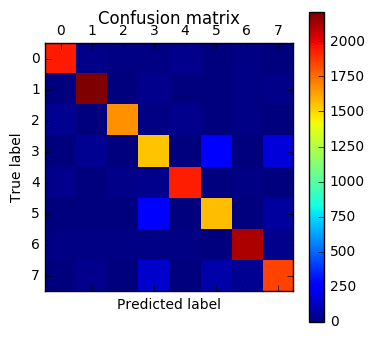

In [18]:
from sklearn.naive_bayes import MultinomialNB

print "Multinomial Naive Bayes Classifier on Test Set"
model = MultinomialNB()
model.fit(X_trn,Y_trn)
#makepredictions
expected = Y_val
predicted = model.predict(X_val)
print "   Validation set accuracy: "
accuracy(expected,predicted)
con_class_matrix(expected,predicted)

Bernoulli Naive Bayes Classifier on Test Set
   Validation set accuracy: 
Accuracy 15153 / 16500 = 0.9184

 Confusion Matrix:
[[1950   12   15   20   27    2   22    3]
 [   7 2222    2   24    2    1    5   18]
 [  25   12 1676   12   31    2   12    3]
 [   3   30    3 1680    7  190    4  159]
 [  28    8   27   18 1947    2   14    1]
 [   2    3    0  221    4 1635    1   41]
 [  19   10   12   11    8    3 2136   17]
 [   1   21    0  131    0   61   30 1907]]

Clasification report:
             precision    recall  f1-score   support

        nfl       0.96      0.95      0.95      2051
     movies       0.96      0.97      0.97      2281
     hockey       0.97      0.95      0.96      1773
       news       0.79      0.81      0.80      2076
  worldnews       0.96      0.95      0.96      2045
   politics       0.86      0.86      0.86      1907
        nba       0.96      0.96      0.96      2216
     soccer       0.89      0.89      0.89      2151

avg / total       0.92     

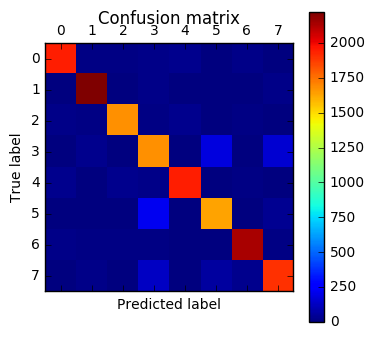

In [17]:
from sklearn.naive_bayes import BernoulliNB

print "Bernoulli Naive Bayes Classifier on Test Set"
gmodel = BernoulliNB()
model.fit(X_trn,Y_trn)
#makepredictions
expected = Y_val
predicted = model.predict(X_val)
print "   Validation set accuracy: "
accuracy(expected,predicted)
con_class_matrix(expected,predicted)

In [ ]:
print "Decision Tree on Test Set"
#dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
#dt.fit(X, y)
model = tree.DecisionTreeClassifier(min_samples_split=20, random_state=99)
model.fit(X_trn,Y_trn)
#makepredictions
expected = Y_val
predicted = model.predict(X_val)
print "   Validation set accuracy: "
accuracy(expected,predicted)
con_class_matrix(expected,predicted)

In [1]:
# print "Grid Search on Naive Bayes............."

# # cv=10, n_jobs=-1

# parameters = {
#     'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'clf__alpha': [1,0.1,0.01,0.001,0.0001,0.000001,0]
# }

# mnb_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True,
#                                                                             sublinear_tf=True)),
#                      ('clf', MultinomialNB())])
# # Train the model
# mnb_clf = GridSearchCV(mnb_clf, parameters)
# mnb_clf.fit(allX,allY.flatten())

# print("\nThe best parameter is:")
# print(mnb_clf.best_estimator_)

# print("\nGrid scores on Training Set:")
# for params, mean_score, scores in mnb_clf.grid_scores_:
#     print "%0.3f (+/-%0.03f) for %r"%(mean_score, scores.std() / 2, params)

    
# print("\nScore for Best Model.")
# print(mnb_clf.best_score_)

In [130]:
print "   Training on all data.................",
sys.stdout.flush()
model.fit(X_all, Y_all)
print "Done."


print "Predictions on test file........................"
sys.stdout.flush()
predictTest = model.predict(X_tst)
predict_file = pd.DataFrame(columns=['id','category'])
predict_file.id= range(X_tst.shape[0])
predict_file.category = predictTest


predict_file.to_csv('predictions/Y_test_MNAIVE.csv',index=False)
print "Done."

   Training on all data................. Done.
Predictions on test file........................
Done.


In [131]:
print '0.91864 Accuracy on Kaggle DataSet'

0.91864 Accuracy on Kaggle DataSet


In [60]:
# allY..flatten()
trnX= allX[:130000]
trnY=allY[:130000].flatten()
tstX=allX[130000:]
tstY=allY[130000:].flatten()


In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import time

# parameters = {
#     'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'clf__loss': ['hinge'],
#     'clf__penalty': ['l2'],
#     'clf__n_iter': [20],
#     'clf__alpha': [0.00001],
#     'clf__fit_intercept': [True]
    
# }

parameters = {
    'vect__ngram_range': [(1, 3),(1,4)],
    'clf__loss': ['modified_huber'],
    'clf__penalty': ['l2'],
    'clf__n_iter': [20],
    'clf__alpha': [0.00001,1e-06],
    'clf__fit_intercept': [True]
    
}


sgd_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True,
                                                                            sublinear_tf=True)),
                     ('clf', SGDClassifier())])
# Train the model
sgd_clf = GridSearchCV(sgd_clf, parameters)
# sgd_clf.fit(trnX,trnY)

# print("\nThe best parameter is:")
# print(sgd_clf.best_estimator_)

# print("\nGrid scores on Training Set:")
# for params, mean_score, scores in sgd_clf.grid_scores_:
#     print "%0.3f (+/-%0.03f) for %r"%(mean_score, scores.std() / 2, params)

    
# print("\nScore for Best Model.")
# print(sgd_clf.best_score_)


In [ ]:

# The best parameter is:
# Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
#         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
#         lowercase=True, max_df=1.0, max_features=None, min_df=1,
#         ngram_range=(1, 3), preprocessor=None, stop_words=None,
#         st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
#        verbose=0, warm_start=False))])

# Grid scores on Training Set:
# 0.919 (+/-0.001) for {'vect__ngram_range': (1, 1), 'clf__n_iter': 10, 'clf__loss': 'hinge', 'clf__fit_intercept'
# : True, 'clf__penalty': 'l1', 'clf__alpha': 1e-05}
# 0.918 (+/-0.000) for {'vect__ngram_range': (1, 2), 'clf__n_iter': 10, 'clf__loss': 'hinge',
# 'clf__fit_intercept': True, 'clf__penalty': 'l1', 'clf__alpha': 1e-05}
# 0.909 (+/-0.000) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 10, 'clf__loss': 'hinge', 
# 'clf__fit_intercept': True, 'clf__penalty': 'l1', 'clf__alpha': 1e-05}
# 0.931 (+/-0.001) for {'vect__ngram_range': (1, 1), 'clf__n_iter': 10, 'clf__loss': 'hinge',
# 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.956 (+/-0.000) for {'vect__ngram_range': (1, 2), 'clf__n_iter': 10,
# 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.958 (+/-0.000) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 10, 'clf__loss': 'hinge', 
# 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.833 (+/-0.001) for {'vect__ngram_range': (1, 1), 'clf__n_iter': 10, 'clf__loss': 'hinge', 
# 'clf__fit_intercept': True, 'clf__penalty': 'l1', 'clf__alpha': 0.0001}
# 0.801 (+/-0.003) for {'vect__ngram_range': (1, 2), 'clf__n_iter': 10, 'clf__loss': 'hinge', 
# 'clf__fit_intercept': True, 'clf__penalty': 'l1', 'clf__alpha': 0.0001}
# 0.775 (+/-0.006) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 10, 'clf__loss': 'hinge', 
# 'clf__fit_intercept': True, 'clf__penalty': 'l1', 'clf__alpha': 0.0001}
# 0.904 (+/-0.001) for {'vect__ngram_range': (1, 1), 'clf__n_iter': 10, 'clf__loss': 'hinge',
# 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 0.0001}
# 0.917 (+/-0.001) for {'vect__ngram_range': (1, 2), 'clf__n_iter': 10, 'clf__loss': 'hinge', 
# 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 0.0001}
# 0.922 (+/-0.001) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 10, 'clf__loss': 'hinge',
# 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 0.0001}

# Score for Best Model.
# 0.95816969697

print '0.96340 Accuracy on Kaggle DataSet'


# The best parameter is:
# Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
#         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
#         lowercase=True, max_df=1.0, max_features=None, min_df=1,
#         ngram_range=(1, 3), preprocessor=None, stop_words=None,
#         st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
#        verbose=0, warm_start=False))])

# Grid scores on Training Set:
# 0.931 (+/-0.001) for {'vect__ngram_range': (1, 1), 'clf__n_iter': 10, 'clf__loss': 'hinge',
# 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.955 (+/-0.000) for {'vect__ngram_range': (1, 2), 'clf__n_iter': 10, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.958 (+/-0.000) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 10, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.931 (+/-0.001) for {'vect__ngram_range': (1, 1), 'clf__n_iter': 20, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.956 (+/-0.000) for {'vect__ngram_range': (1, 2), 'clf__n_iter': 20, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.958 (+/-0.000) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 20, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.904 (+/-0.001) for {'vect__ngram_range': (1, 1), 'clf__n_iter': 10, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 0.0001}
# 0.917 (+/-0.001) for {'vect__ngram_range': (1, 2), 'clf__n_iter': 10, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 0.0001}
# 0.922 (+/-0.001) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 10, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 0.0001}
# 0.904 (+/-0.001) for {'vect__ngram_range': (1, 1), 'clf__n_iter': 20, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 0.0001}
# 0.917 (+/-0.001) for {'vect__ngram_range': (1, 2), 'clf__n_iter': 20, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 0.0001}
# 0.922 (+/-0.001) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 20, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 0.0001}

# Score for Best Model.
# 0.958484848485

print '0.96377 Accuracy on Kaggle DataSet'


# The best parameter is:
# Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
#         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
#         lowercase=True, max_df=1.0, max_features=None, min_df=1,
#         ngram_range=(1, 3), preprocessor=None, stop_words=None,
#         st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
#        verbose=0, warm_start=False))])

# Grid scores on Training Set:
# 0.935 (+/-0.001) for {'vect__ngram_range': (1, 1), 'clf__n_iter': 20, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.958 (+/-0.000) for {'vect__ngram_range': (1, 2), 'clf__n_iter': 20, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.960 (+/-0.000) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 20, 'clf__loss': 'hinge', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}

# Score for Best Model.
# 0.960151515152

print '0.96482 Accuracy on Kaggle DataSet'


# The best parameter is:
# Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
#         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
#         lowercase=True, max_df=1.0, max_features=None, min_df=1,
#         ngram_range=(1, 4), preprocessor=None, stop_words=None,
#         st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
#        verbose=0, warm_start=False))])

# Grid scores on Training Set:
# 0.960 (+/-0.000) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 20, 
# 'clf__loss': 'modified_huber', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.960 (+/-0.000) for {'vect__ngram_range': (1, 4), 'clf__n_iter': 20, 
# 'clf__loss': 'modified_huber', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-05}
# 0.963 (+/-0.000) for {'vect__ngram_range': (1, 3), 'clf__n_iter': 20, 
# 'clf__loss': 'modified_huber', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-06}
# 0.964 (+/-0.000) for {'vect__ngram_range': (1, 4), 'clf__n_iter': 20, 
# 'clf__loss': 'modified_huber', 'clf__fit_intercept': True, 'clf__penalty': 'l2', 'clf__alpha': 1e-06}

# Score for Best Model.
# 0.963987878788

print '0.97133  Accuracy on Kaggle DataSet'

Testing on validation Set...........
   Validation set accuracy: 
Accuracy 33807 / 35000 = 0.9659

 Confusion Matrix:
[[4323    8   15    6   18    3   30    5]
 [   3 4737    4   14    1    1    3    7]
 [  31    9 3792    6   26    2   13    3]
 [   4   29    4 4043   18  171    4  180]
 [  15   10   27    9 4216    1   11    0]
 [   0    5    2  186    1 3848    4   55]
 [  22   10    7    4   14    1 4503   19]
 [   0   11    0   94    1   50   16 4345]]

Clasification report:
             precision    recall  f1-score   support

        nfl       0.98      0.98      0.98      4408
     movies       0.98      0.99      0.99      4770
     hockey       0.98      0.98      0.98      3882
       news       0.93      0.91      0.92      4453
  worldnews       0.98      0.98      0.98      4289
   politics       0.94      0.94      0.94      4101
        nba       0.98      0.98      0.98      4580
     soccer       0.94      0.96      0.95      4517

avg / total       0.97      0.97   

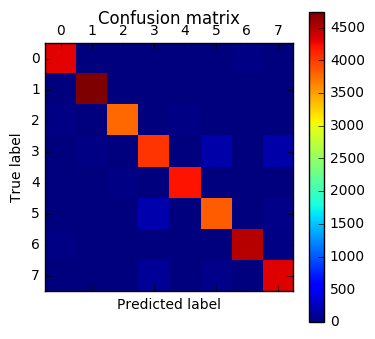

In [63]:
# SGD using given best parameters


print "Testing on validation Set..........."

expected = tstY
predicted = sgd_clf.predict(tstX)
print "   Validation set accuracy: "
accuracy(expected,predicted)
con_class_matrix(expected,predicted)


In [34]:
print "Predictions on test file........................"
sys.stdout.flush()

predictTest = sgd_clf.predict(testX)
predict_file = pd.DataFrame(columns=['id','category'])
predict_file.id= range(testX.shape[0])
predict_file.category = predictTest


predict_file.to_csv('predictions/Y_test_SGD4.csv',index=False)
print "Done."
        

Predictions on test file........................
Done.


In [21]:
from sklearn.ensemble import BaggingClassifier
# from sklearn.cross_validation import KFold 

# clf__loss': ['modified_huber'],
#     'clf__penalty': ['l2'],
#     'clf__n_iter': [20],
#     'clf__alpha': [0.00001,1e-06],
#     'clf__fit_intercept': [True]
        
sgd =  SGDClassifier(penalty='l2',n_iter=20,alpha=1e-06,fit_intercept=True,loss='modified_huber')
print "   Building ensemble....................",
sys.stdout.flush()
n_estimators = 100
seed = 7


# kfold = KFold(n_splits=10, random_state=seed)
model = BaggingClassifier(sgd, n_estimators=n_estimators,
                          bootstrap = True, n_jobs=-1, random_state=seed)
score = cross_val_score(model, X_all, Y_all, cv=5)
print score.mean()

   Building ensemble.................... 0.92976359324


In [ ]:
# Trying Adaboost

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

AdaBoost_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                     ('clf', AdaBoostClassifier())])

# parameters = {}
parameters = {
    'vect__ngram_range': [(1, 3),(1,4)],
    'clf__n_estimators': [20,10],
#     'clf__penalty': ['l2'],
    'clf__learning_rate': [1,0.001,0.0001],
    'clf__algorithm' : ['SAMME', 'SAMME.R']
}

AdaBoost_clf = GridSearchCV(AdaBoost_clf, parameters)
AdaBoost_clf.fit(allX,allY.flatten())

print("\nThe best parameter is:")
print(AdaBoost_clf.best_estimator_)

print("\nGrid scores on train set:")
for params, mean_score, scores in AdaBoost_clf.grid_scores_:
    print "%0.3f (+/-%0.03f) for %r"%(mean_score, scores.std() / 2, params)
    
    
print("\nThe accuracy for the best model.")
print(AdaBoost_clf.best_score_)
